In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
import warnings as warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import plotly.express as px
import pandas_profiling
from pandas_profiling import ProfileReport

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [81]:
#Function to get phi_k correlation matrix from pandas profiling
def get_phi_k_corr(df,title):
    profile=ProfileReport(df, title=title)
    phi_k=pd.DataFrame([])
    dict=profile.description_set
    for keys,values in dict.items():
            try:
                for keys_ in dict.get(keys).keys():
                    try:
                        if keys_=='phi_k':
                            phi_k= pd.concat([phi_k,dict.get(keys).get(keys_)])
                    except AttributeError as e:
                        pass
            except AttributeError as e:
                pass
    return phi_k    

#print correlation matrix
def print_corr_matrix(df,title):
    plt.title(title, size=20)
    mask = np.triu(np.ones_like(df, dtype=np.bool))
    sns.set(rc={'figure.figsize':(15,8)})
    sns.heatmap(df, xticklabels=df.columns, yticklabels=df.columns, annot=True, 
                linewidths=.5, vmin = -1.0, vmax = 1.0, mask = mask,
                cmap=sns.diverging_palette(-10, 240, sep=70, n=7), fmt='.2')
    plt.show()

## Data Exploration

In [82]:
df = pd.read_csv(r'C:\Users\Admin\Desktop\Lessons NOVA\2nd Semester\Business Cases\Project\Case 2\H2.csv')

In [83]:
df['Cancel'] = df['ReservationStatus'].map({'Check-Out': 0, 'No-Show': 0,'Canceled':1})
df['NoShow'] = df['ReservationStatus'].map({'Check-Out': 0, 'No-Show': 1,'Canceled':0})
df.drop(['ReservationStatus'],axis=1,inplace=True)
df.drop(['IsCanceled'],axis=1,inplace=True)

print(df['Cancel'].value_counts())
print(df['NoShow'].value_counts())


0    47144
1    32186
Name: Cancel, dtype: int64
0    78414
1      916
Name: NoShow, dtype: int64


In [84]:
df_cancel = df[df['NoShow']!=1].reset_index()
df_cancel.drop(['NoShow', 'index'], axis=1,inplace=True)

In [85]:
df_cancel.columns

Index(['LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatusDate', 'Cancel'],
      dtype='object')

In [86]:
df_cancel.shape

(78414, 30)

In [87]:
df_cancel.head()

LeadTime  ArrivalDateYear ArrivalDateMonth  ArrivalDateWeekNumber  \
0         6             2015             July                     27   
1        88             2015             July                     27   
2        65             2015             July                     27   
3        92             2015             July                     27   
4       100             2015             July                     27   

   ArrivalDateDayOfMonth  StaysInWeekendNights  StaysInWeekNights  Adults  \
0                      1                     0                  2       1   
1                      1                     0                  4       2   
2                      1                     0                  4       1   
3                      1                     2                  4       2   
4                      2                     0                  2       2   

   Children  Babies  ...      DepositType        Agent      Company  \
0       0.0       0  ...  No Deposit                 6         NULL   
1       0.0       0  ...  No Deposit                 9         NULL   
2       0.0       0  ...  No Deposit                 9         NULL   
3       0.0       0  ...  No Deposit                 9         NULL   
4       0.0       0  ...  No Deposit                 9         NULL   

  DaysInWaitingList  CustomerType   ADR  RequiredCarParkingSpaces  \
0                 0     Transient   0.0                         0   
1                 0     Transient  76.5                         0   
2                 0     Transient  68.0                         0   
3                 0     Transient  76.5                         0   
4                 0     Transient  76.5                         0   

  TotalOfSpecialRequests ReservationStatusDate  Cancel  
0                      0            2015-07-03       0  
1                      1            2015-07-01       1  
2                      1            2015-04-30       1  
3                      2            2015-06-23       1  
4                      1            2015-04-02       1  

[5 rows x 30 columns]

In [88]:
# DepositType data quality compromised hence the client instructed us to ignore the data. ReservationStatusDate since it doesn't mean much
df_cancel.drop(['ReservationStatusDate', 'DepositType','Country'], axis=1, inplace=True)

In [89]:
percentage = []
percentage.append(df_cancel['Cancel'].mean())
percentage.append(1-df_cancel['Cancel'].mean())

In [90]:
percentage

[0.41046241742545975, 0.5895375825745403]

In [91]:
colors=['yellowgreen', 'gray']

In [92]:
fig = px.pie(values=percentage, names=['Canceled', 'Not Canceled'], title='Reservations', color={'Canceled' : 'yellowgreen', 'Not Canceled' : 'gray'})
fig.update_traces(marker = dict(colors=colors))
fig.show()

Not very imbalanced dataset.

In [93]:
df_cancel.head(5)

LeadTime  ArrivalDateYear ArrivalDateMonth  ArrivalDateWeekNumber  \
0         6             2015             July                     27   
1        88             2015             July                     27   
2        65             2015             July                     27   
3        92             2015             July                     27   
4       100             2015             July                     27   

   ArrivalDateDayOfMonth  StaysInWeekendNights  StaysInWeekNights  Adults  \
0                      1                     0                  2       1   
1                      1                     0                  4       2   
2                      1                     0                  4       1   
3                      1                     2                  4       2   
4                      2                     0                  2       2   

   Children  Babies  ...  AssignedRoomType BookingChanges        Agent  \
0       0.0       0  ...  A                             0            6   
1       0.0       0  ...  A                             0            9   
2       0.0       0  ...  A                             0            9   
3       0.0       0  ...  A                             0            9   
4       0.0       0  ...  A                             0            9   

       Company  DaysInWaitingList  CustomerType   ADR  \
0         NULL                  0     Transient   0.0   
1         NULL                  0     Transient  76.5   
2         NULL                  0     Transient  68.0   
3         NULL                  0     Transient  76.5   
4         NULL                  0     Transient  76.5   

  RequiredCarParkingSpaces  TotalOfSpecialRequests Cancel  
0                        0                       0      0  
1                        0                       1      1  
2                        0                       1      1  
3                        0                       2      1  
4                        0                       1      1  

[5 rows x 27 columns]

#### Data Types

In [94]:
df.dtypes

LeadTime                         int64
ArrivalDateYear                  int64
ArrivalDateMonth                object
ArrivalDateWeekNumber            int64
ArrivalDateDayOfMonth            int64
StaysInWeekendNights             int64
StaysInWeekNights                int64
Adults                           int64
Children                       float64
Babies                           int64
Meal                            object
Country                         object
MarketSegment                   object
DistributionChannel             object
IsRepeatedGuest                  int64
PreviousCancellations            int64
PreviousBookingsNotCanceled      int64
ReservedRoomType                object
AssignedRoomType                object
BookingChanges                   int64
DepositType                     object
Agent                           object
Company                         object
DaysInWaitingList                int64
CustomerType                    object
ADR                      

#### Missing values

In [95]:
df.isna().sum()[df.isna().sum()>0]

Children     4
Country     24
dtype: int64

In [96]:
df[df.isna().any(axis=1)]

LeadTime  ArrivalDateYear ArrivalDateMonth  ArrivalDateWeekNumber  \
540           2             2015           August                     32   
607           1             2015           August                     32   
619           1             2015           August                     32   
1100          8             2015           August                     33   
4831        193             2015          October                     42   
4832        193             2015          October                     42   
4833        193             2015          October                     42   
4834        193             2015          October                     42   
4835        193             2015          October                     42   
4836        193             2015          October                     42   
4837        193             2015          October                     42   
4838        193             2015          October                     42   
4839        193             2015          October                     42   
4841        193             2015          October                     42   
4842        193             2015          October                     42   
4843        193             2015          October                     42   
4844        193             2015          October                     42   
4845        193             2015          October                     42   
20591         0             2016         November                     47   
21184         0             2016         December                     50   
21185         0             2016         December                     50   
21189         0             2016         December                     50   
25847         0             2017            April                     15   
25848         0             2017            April                     15   
25849         0             2017            April                     15   
25850         0             2017            April                     15   
40770         4             2015         November                     48   
61428         1             2016         November                     47   

       ArrivalDateDayOfMonth  StaysInWeekendNights  StaysInWeekNights  Adults  \
540                        3                     1                  0       2   
607                        5                     0                  2       2   
619                        5                     0                  2       3   
1100                      13                     2                  5       2   
4831                      15                     0                  3       2   
4832                      15                     0                  3       2   
4833                      15                     0                  3       2   
4834                      15                     0                  3       2   
4835                      15                     0                  3       2   
4836                      15                     0                  3       2   
4837                      15                     0                  3       2   
4838                      15                     0                  3       2   
4839                      15                     0                  3       2   
4841                      15                     0                  3       2   
4842                      15                     0                  3       2   
4843                      15                     0                  3       2   
4844                      15                     0                  3       2   
4845                      15                     0                  3       2   
20591                     17                     4                 11       0   
21184                      6                     0                  0       0   
21185                      6                     0                  0       0   
21189               

#### Correlation Matrix

In [97]:
# corr = np.round(df[metric].corr(),2)
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True

# plt.figure(figsize=(10,10))
# sns.heatmap(corr,mask=mask, annot=True, cbar=True, linewidths=0.1)

In [98]:
# #Group A - Get correlation matrix
# phi_k_c=get_phi_k_corr(df_cancel,'')
# #Print matrix
# print_corr_matrix(phi_k_c,'Phik - IsCancel')
# phi_k_c.loc[:,'Cancel'].sort_values(ascending=False)

#### Ditribution of Values

In [99]:
metric = ['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'Babies', 'PreviousCancellations',\
         'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList', 'ADR', 'RequiredCarParkingSpaces',\
          'TotalOfSpecialRequests',\
         ]
target = ['Cancel']
non_metric = df_cancel.columns.drop(metric)
non_metric = non_metric.drop(target)

Text(0.5, 0.98, "Numeric Variables' Histograms")

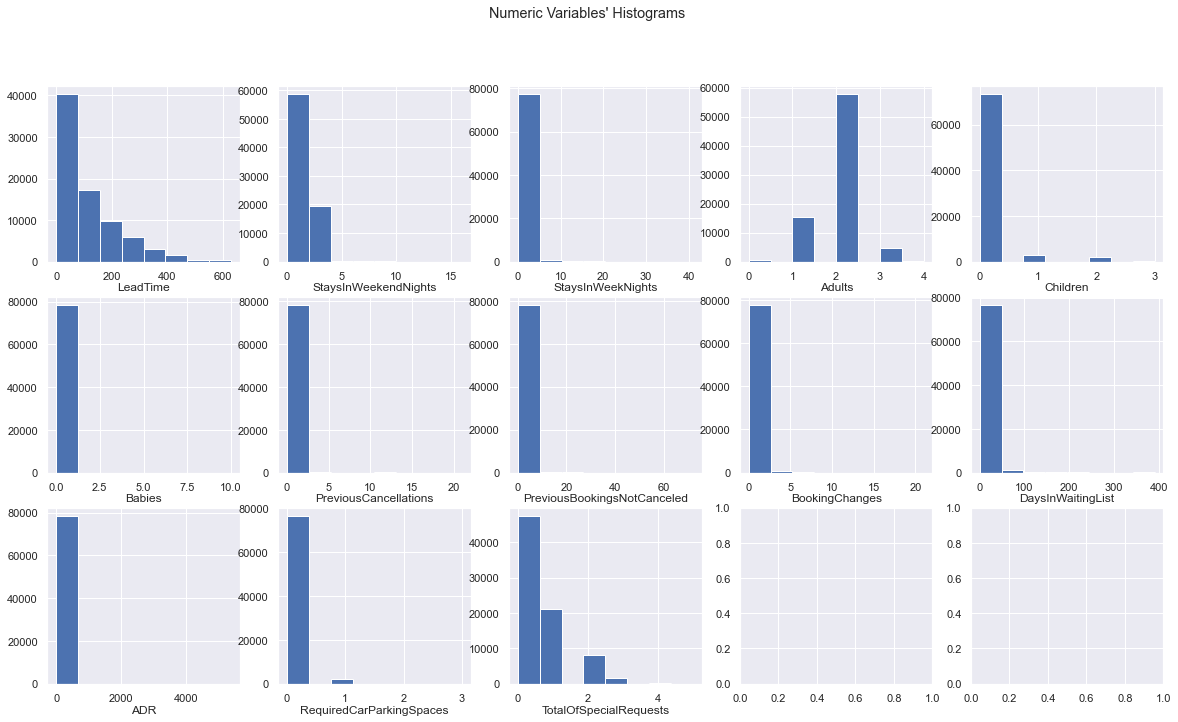

In [100]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, ceil(len(metric) / 3), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram
for ax, feat in zip(axes.flatten(), metric):
    ax.hist(df_cancel[feat], bins=8)
    ax.set_title(feat, y=-0.20)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

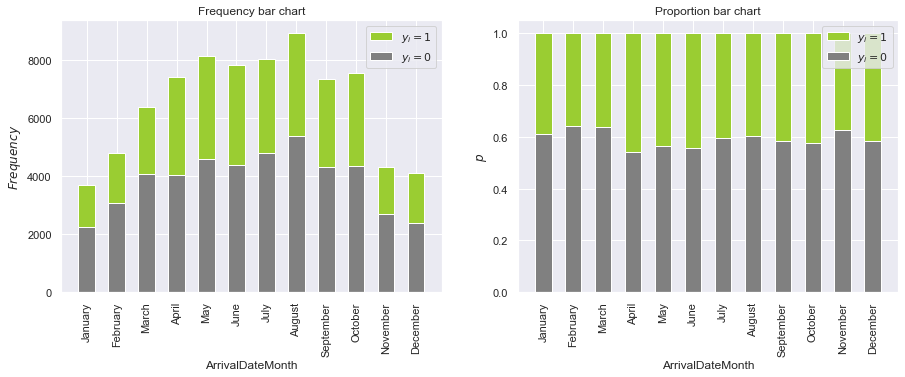

In [101]:
#Proportion and Frequency chart for ArrivalDateMonth
cont_tab = pd.crosstab(df_cancel['ArrivalDateMonth'], df_cancel['Cancel'], margins = True)
cats = ['January', 'February', 'March', 'April','May','June', 'July', 'August','September', 'October', 'November', 'December']
cont_tab.index = pd.CategoricalIndex(cont_tab.index, categories=cats, ordered=True)
cont_tab = cont_tab.sort_index()
        
fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
p1 = plt.bar(cats, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
p2 = plt.bar(cats, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
plt.title("Frequency bar chart")
plt.xlabel('ArrivalDateMonth')
plt.ylabel("$Frequency$")
plt.xticks(rotation=90)

obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])

plt.subplot(122)
p1 = plt.bar(cats, obs_pct[0], 0.55, color="gray") #
p2 = plt.bar(cats, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen") #
plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
plt.title("Proportion bar chart")
plt.xlabel('ArrivalDateMonth')
plt.ylabel("$p$")
plt.xticks(rotation=90)

plt.show()

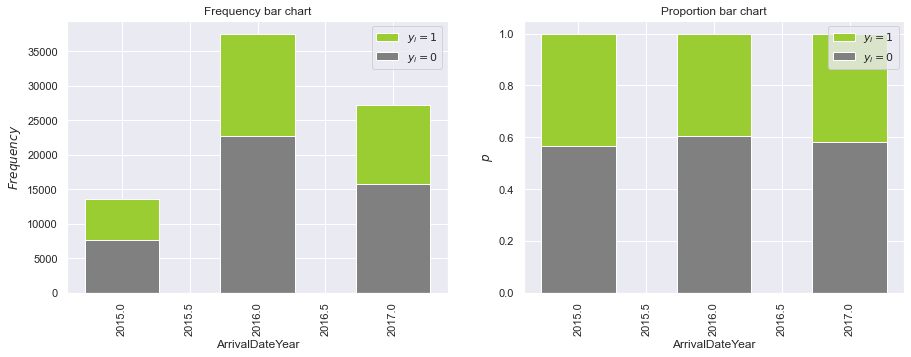

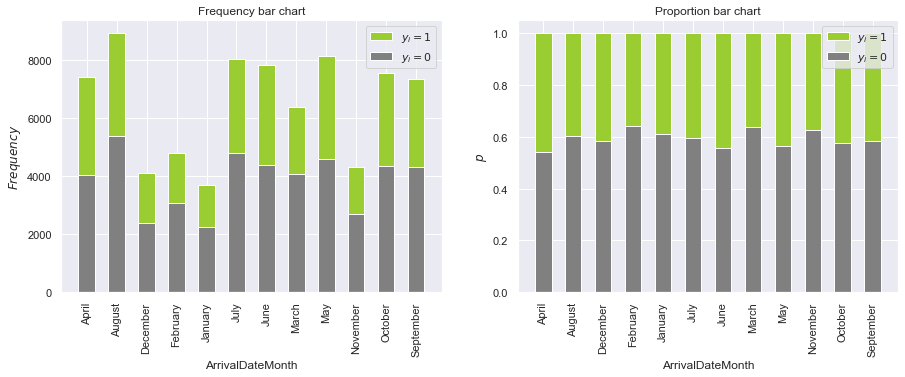

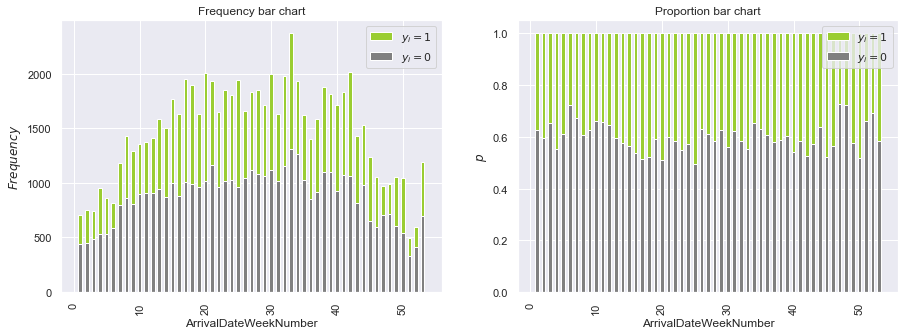

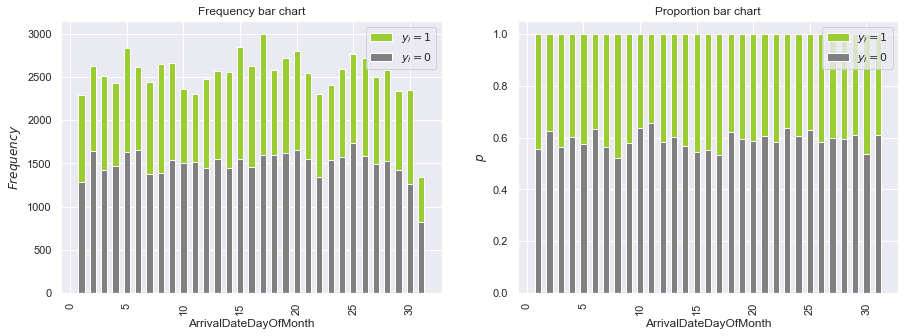

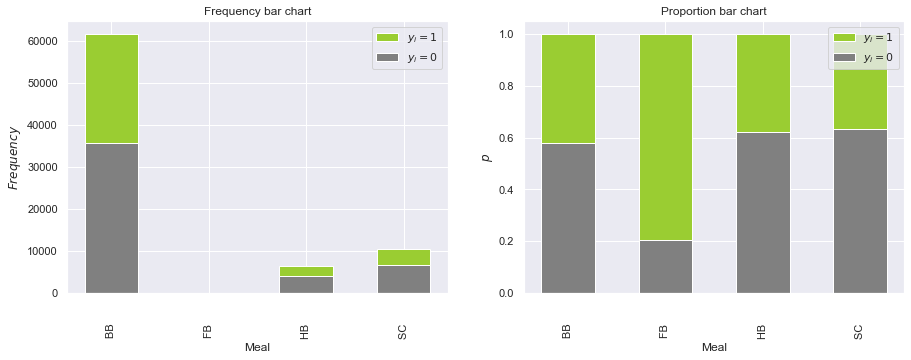

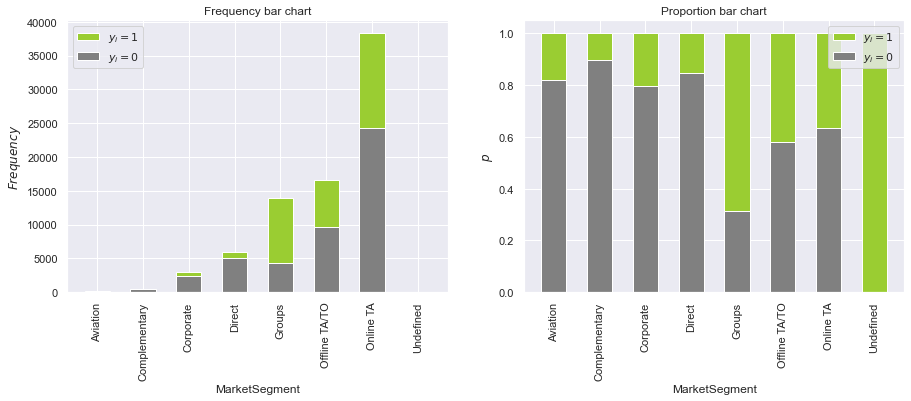

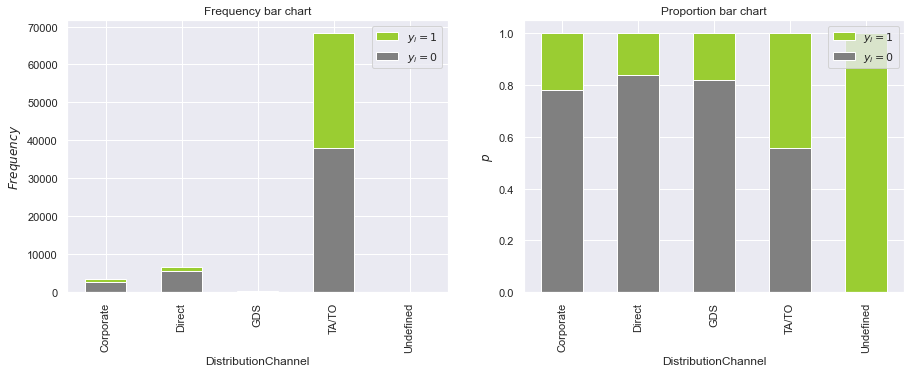

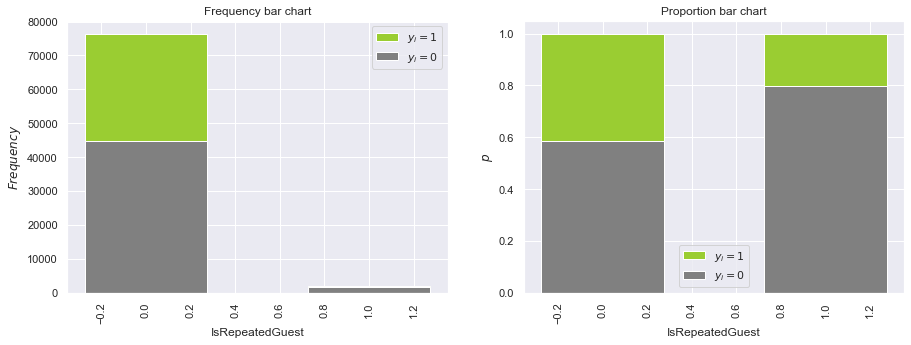

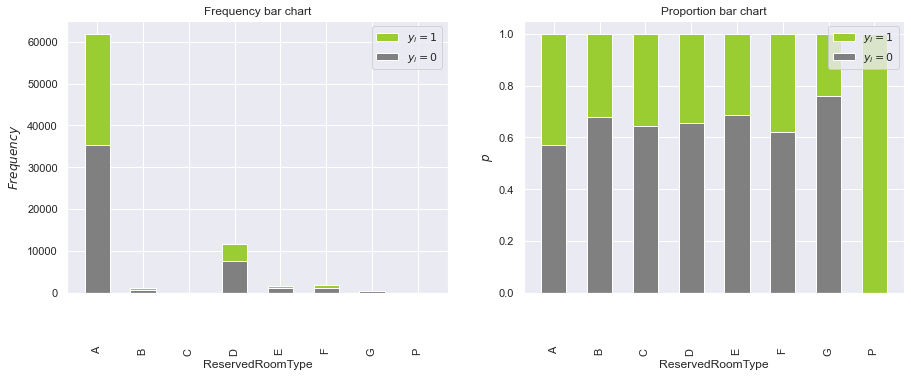

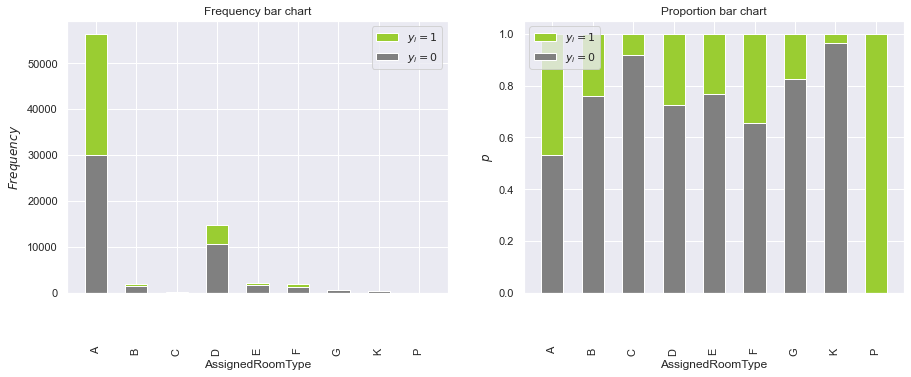

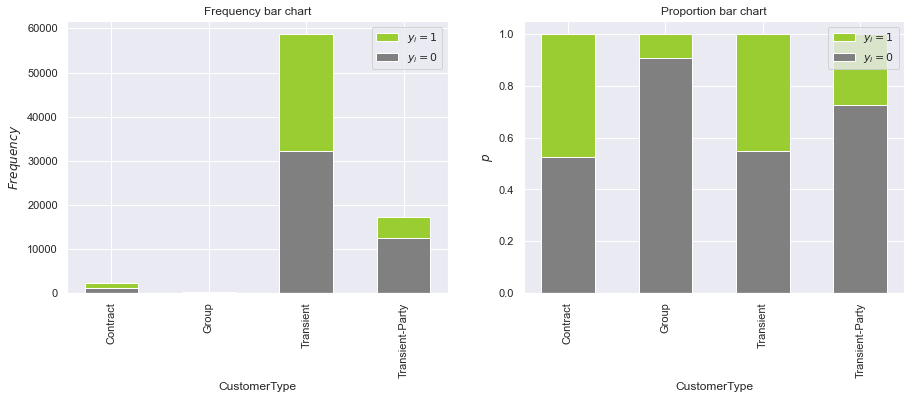

In [102]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")
    plt.xticks(rotation=90)

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray") #
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen") #
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")
    plt.xticks(rotation=90)

    plt.show()

#dropped variables because their graphs are not very informative since there are a lot of categories
for i in non_metric.drop(['Company', 'Agent']):
    bar_charts_categorical(df_cancel, i, 'Cancel')

In [103]:
#drop 'ArrivalDateYear', we cant control it, also its not going to repeat

#### Box Plots for Outlier Analysis

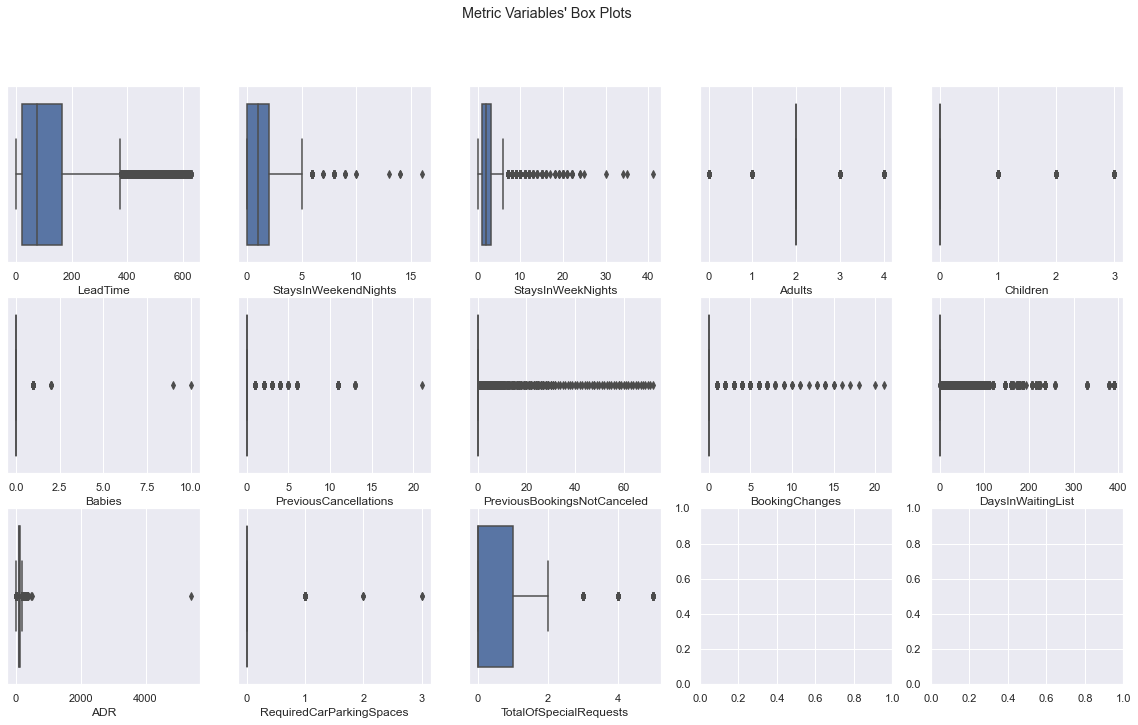

In [104]:
with warnings.catch_warnings():
    # this will suppress all warnings in this block
    warnings.simplefilter("ignore")
    
    # All Metric Variables' Box Plots in one figure
    sns.set()

    # Prepare figure. Create individual axes where each box plot will be placed
    fig, axes = plt.subplots(3,ceil(len(metric) / 3), figsize=(20, 11))

    # Plot data
    # Iterate across axes objects and associate each box plot:
    for ax, feat in zip(axes.flatten(), metric):
        sns.boxplot(df_cancel[feat], ax=ax)

    # Layout
    # Add a centered title to the figure:
    title = "Metric Variables' Box Plots"

    plt.suptitle(title)

    plt.show()

Zero adults? 10 babies? More than 10 cancellations? 

## Data Preprocessing

#### Handling missing values

In [105]:
# we can either drop or fill them with knn imputer. they are not much, so we will drop them
df_cancel.dropna(inplace=True)

In [106]:
df_cancel.shape

(78410, 27)

#### Handling Outliers

In [107]:
# nobody stayed?
df_cancel[(df_cancel.Adults == 0) & (df_cancel.Children == 0) & (df_cancel.Babies==0.0)]

LeadTime  ArrivalDateYear ArrivalDateMonth  ArrivalDateWeekNumber  \
316         132             2015             July                     30   
844           0             2015           August                     33   
941           0             2015           August                     33   
977           0             2015           August                     33   
2358          1             2015        September                     37   
...         ...              ...              ...                    ...   
74054       107             2017             June                     26   
74116         1             2017             June                     26   
75276        44             2017             July                     28   
75559         2             2017             July                     28   
76112       170             2017             July                     30   

       ArrivalDateDayOfMonth  StaysInWeekendNights  StaysInWeekNights  Adults  \
316                       23                     2                  5       0   
844                        9                     2                  0       0   
941                       10                     9                 20       0   
977                       11                     0                  4       0   
2358                       6                     2                  0       0   
...                      ...                   ...                ...     ...   
74054                     27                     0                  3       0   
74116                     30                     0                  1       0   
75276                     15                     1                  1       0   
75559                     15                     2                  5       0   
76112                     27                     0                  2       0   

       Children  Babies  ...  AssignedRoomType BookingChanges        Agent  \
316         0.0       0  ...  A                             4            1   
844         0.0       0  ...  B                             0            9   
941         0.0       0  ...  K                            20         NULL   
977         0.0       0  ...  K                             4         NULL   
2358        0.0       0  ...  A                             0            1   
...         ...     ...  ...               ...            ...          ...   
74054       0.0       0  ...  A                             1            7   
74116       0.0       0  ...  K                             0         NULL   
75276       0.0       0  ...  K                             2          425   
75559       0.0       0  ...  K                             1            9   
76112       0.0       0  ...  A                             0           52   

           Company  DaysInWaitingList     CustomerType     ADR  \
316           NULL                  0  Transient-Party    0.00   
844           NULL                  0         Contract    0.00   
941             47                  0        Transient    0.00   
977             49                  0  Transient-Party    0.00   
2358          NULL                  0  Transient-Party    0.00   
...            ...                ...              ...     ...   
74054         NULL                  0        Transient  100.80   
74116         NULL                  0        Transient    0.00   
75276         NULL                  0        Transient   73.80   
75559         NULL                  0  Transient-Party   22.86   
76112         NULL                  0        Transient    0.00   

      RequiredCarParkingSpaces  TotalOfSpecialRequests Cancel  
316                          0                       0      0  
844                          0                       0      0  
941                          0                       0      0  
977                          0                       1      0  
2358                         0                       0      1  
...    

In [108]:
df_cancel.drop(df_cancel[(df_cancel.Adults == 0) & (df_cancel.Children == 0) & (df_cancel.Babies==0.0)].index, inplace=True) #inplace=True

In [109]:
# with 10 babies?
df_cancel[df_cancel.Babies>5][['Adults', 'Children', 'Babies']]

Adults  Children  Babies
6497        2       0.0      10
37754       1       0.0       9

In [110]:
df_cancel.drop(df_cancel[df_cancel.Babies>5].index, inplace = True) #inplace = True

In [111]:
# too many cancellations?
df_cancel[(df_cancel.PreviousCancellations>10) & (df_cancel.PreviousBookingsNotCanceled == 0) ][['Adults', 'Children', 'Babies', 'PreviousCancellations', 'PreviousBookingsNotCanceled']]

Adults  Children  Babies  PreviousCancellations  \
32838       2       0.0       0                     21   
36454       2       0.0       0                     13   
39118       2       0.0       0                     11   
39119       2       0.0       0                     11   
39120       1       0.0       0                     11   
39121       2       0.0       0                     11   
39122       2       0.0       0                     11   

       PreviousBookingsNotCanceled  
32838                            0  
36454                            0  
39118                            0  
39119                            0  
39120                            0  
39121                            0  
39122                            0

In [112]:
df_cancel.drop(df_cancel[(df_cancel.PreviousCancellations>10) & (df_cancel.PreviousBookingsNotCanceled == 0)].index, inplace = True) #inplace=True

In [113]:
df_cancel[(df_cancel['StaysInWeekNights'] == 0) & (df_cancel['StaysInWeekendNights'] == 0)]

LeadTime  ArrivalDateYear ArrivalDateMonth  ArrivalDateWeekNumber  \
457           0             2015             July                     31   
458           0             2015             July                     31   
942           0             2015           August                     33   
1060          0             2015           August                     33   
1933          0             2015           August                     36   
...         ...              ...              ...                    ...   
74508        15             2017             July                     27   
76725         0             2017           August                     32   
77053         0             2017           August                     33   
77655        78             2017           August                     34   
77987         1             2017           August                     35   

       ArrivalDateDayOfMonth  StaysInWeekendNights  StaysInWeekNights  Adults  \
457                       28                     0                  0       2   
458                       28                     0                  0       2   
942                       11                     0                  0       2   
1060                      13                     0                  0       2   
1933                      30                     0                  0       1   
...                      ...                   ...                ...     ...   
74508                      6                     0                  0       1   
76725                      8                     0                  0       2   
77053                     14                     0                  0       2   
77655                     23                     0                  0       1   
77987                     27                     0                  0       2   

       Children  Babies  ...  AssignedRoomType BookingChanges        Agent  \
457         0.0       0  ...  A                             0         NULL   
458         0.0       0  ...  A                             2         NULL   
942         0.0       0  ...  E                             1         NULL   
1060        0.0       0  ...  K                             0         NULL   
1933        0.0       0  ...  A                             0         NULL   
...         ...     ...  ...               ...            ...          ...   
74508       0.0       0  ...  A                             0           14   
76725       0.0       0  ...  A                             0          262   
77053       0.0       0  ...  A                             0         NULL   
77655       0.0       0  ...  K                             7           98   
77987       0.0       0  ...  A                             0         NULL   

           Company  DaysInWaitingList     CustomerType  ADR  \
457           NULL                  0        Transient  0.0   
458           NULL                  0        Transient  0.0   
942           NULL                  0        Transient  0.0   
1060          NULL                  0         Contract  0.0   
1933          NULL                  0        Transient  0.0   
...            ...                ...              ...  ...   
74508         NULL                  0  Transient-Party  0.0   
76725         NULL                  0        Transient  0.0   
77053         NULL                  0        Transient  0.0   
77655         NULL                  0  Transient-Party  0.0   
77987         NULL                  0        Transient  0.0   

      RequiredCarParkingSpaces  TotalOfSpecialRequests Cancel  
457                          0                       0      0  
458                          0                       0      0  
942                          0                       0      0  
1060                         0                       2      0  
1933                         0                       0      0  
...                        ...             

In [114]:
#no stay
df_cancel.drop(df_cancel[(df_cancel['StaysInWeekNights'] == 0) & (df_cancel['StaysInWeekendNights'] == 0)].index, inplace = True) #inplace=True

In [115]:
#customers that didnt stay but used services

df_cancel[df_cancel['ADR']==0]

LeadTime  ArrivalDateYear ArrivalDateMonth  ArrivalDateWeekNumber  \
0             6             2015             July                     27   
124           0             2015             July                     29   
128           0             2015             July                     29   
154          18             2015             July                     29   
184          12             2015             July                     29   
...         ...              ...              ...                    ...   
76984         9             2017           August                     32   
77166       504             2017           August                     32   
77786         1             2017           August                     34   
78126       518             2017           August                     34   
78148         0             2017           August                     35   

       ArrivalDateDayOfMonth  StaysInWeekendNights  StaysInWeekNights  Adults  \
0                          1                     0                  2       1   
124                       15                     0                  1       2   
128                       15                     2                  5       2   
154                       18                     1                  1       1   
184                       18                     2                  2       1   
...                      ...                   ...                ...     ...   
76984                     12                     2                  1       2   
77166                     12                     2                  1       1   
77786                     24                     0                  1       2   
78126                     26                     2                  1       1   
78148                     29                     0                  1       1   

       Children  Babies  ...  AssignedRoomType BookingChanges        Agent  \
0           0.0       0  ...  A                             0            6   
124         0.0       0  ...  F                             0         NULL   
128         0.0       0  ...  A                             4         NULL   
154         0.0       0  ...  A                             0            1   
184         0.0       0  ...  A                             0            1   
...         ...     ...  ...               ...            ...          ...   
76984       0.0       0  ...  K                             3            9   
77166       0.0       0  ...  A                             3          229   
77786       1.0       0  ...  D                             1         NULL   
78126       0.0       0  ...  A                             1          229   
78148       0.0       0  ...  A                             0         NULL   

           Company  DaysInWaitingList     CustomerType  ADR  \
0             NULL                  0        Transient  0.0   
124           NULL                  0        Transient  0.0   
128           NULL                  0        Transient  0.0   
154           NULL                  0  Transient-Party  0.0   
184           NULL                  0  Transient-Party  0.0   
...            ...                ...              ...  ...   
76984         NULL                  0  Transient-Party  0.0   
77166         NULL                  0  Transient-Party  0.0   
77786         NULL                  0        Transient  0.0   
78126         NULL                  0  Transient-Party  0.0   
78148           72                  0        Transient  0.0   

      RequiredCarParkingSpaces  TotalOfSpecialRequests Cancel  
0                            0                       0      0  
124                          0                       0      1  
128                          0                       0      0  
154                          0                       0      0  
184                          0                       0      0  
...                        ...             

In [116]:
df_cancel.drop(df_cancel[df_cancel['ADR']==0].index,inplace=True)

In [117]:
(78410 - df_cancel.shape[0])/78410

0.01571228159673511

##### Change company and agent nulls

In [118]:
df_cancel.Agent.value_counts()

          9    31467
       NULL     7393
          1     7023
         14     3531
          7     3488
               ...  
        346        1
        416        1
        265        1
        247        1
         54        1
Name: Agent, Length: 222, dtype: int64

In [124]:
df_cancel['Agent'] = df_cancel['Agent'].replace('       NULL', '0')

#### Feature Engineering

In [119]:
df_cancel.Company.value_counts()

       NULL    73867
         40      893
         67      264
        153      199
        219      136
               ...  
        446        1
        356        1
         84        1
          8        1
        478        1
Name: Company, Length: 200, dtype: int64

In [120]:
df_cancel['not_company'] = np.where(df_cancel['Company'] != '       NULL', '1', '0')

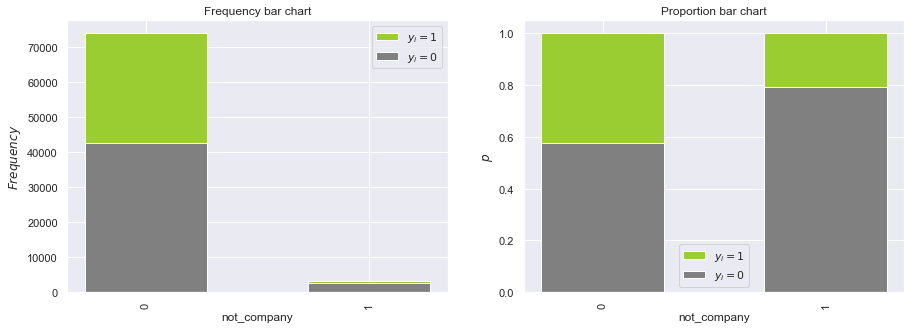

In [121]:
bar_charts_categorical(df_cancel, 'not_company', 'Cancel')

In [125]:
df_cancel.drop('Company', axis=1,inplace=True)

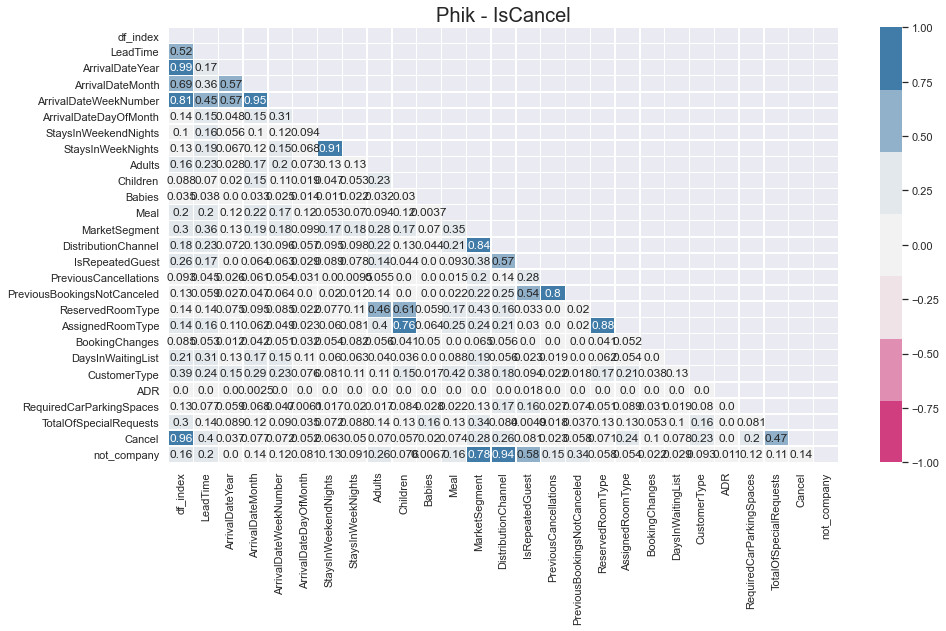

Cancel                         1.000000
df_index                       0.964068
TotalOfSpecialRequests         0.469978
LeadTime                       0.403316
MarketSegment                  0.281071
DistributionChannel            0.263809
AssignedRoomType               0.244663
CustomerType                   0.234958
RequiredCarParkingSpaces       0.200312
not_company                    0.139276
BookingChanges                 0.100904
IsRepeatedGuest                0.080670
DaysInWaitingList              0.078409
ArrivalDateMonth               0.076760
Meal                           0.074493
ArrivalDateWeekNumber          0.071593
ReservedRoomType               0.070661
Adults                         0.070033
StaysInWeekendNights           0.063338
PreviousBookingsNotCanceled    0.057748
Children                       0.056878
ArrivalDateDayOfMonth          0.051738
StaysInWeekNights              0.049537
ArrivalDateYear                0.036752
PreviousCancellations          0.023126


In [123]:
#Group A - Get correlation matrix
phi_k_c=get_phi_k_corr(df_cancel,'')
#Print matrix
print_corr_matrix(phi_k_c,'Phik - IsCancel')
phi_k_c.loc[:,'Cancel'].sort_values(ascending=False)

In [185]:
#drop 'ArrivalDateYear', we cant control it, also its not going to repeat
#drop 'ArrivalDateMonth' since its correlated and other is more granular
#marketsegment vs distribution channel ???
#change has_baby, has_children(only hasbaby)
#check for assigned and reserved room type if they are different

##### Drop 'ArrivalDateYear', 'ArrivalDateMonth'

In [126]:
df_cancel.drop(['ArrivalDateYear', 'ArrivalDateMonth'], axis=1,inplace=True)

##### CREATE has_babies

In [127]:
df_cancel['Babies'].value_counts()

0    76837
1      335
2        6
Name: Babies, dtype: int64

In [128]:
df_cancel['BabiesO'] = df_cancel['Babies'].map(str)
df_cancel['has_Babies'] = df_cancel['BabiesO'].map({'0': 0, '1': 1,'2':1,})
df_cancel.drop('BabiesO', axis=1,inplace=True)
df_cancel['has_Babies'].value_counts()

0    76837
1      341
Name: has_Babies, dtype: int64

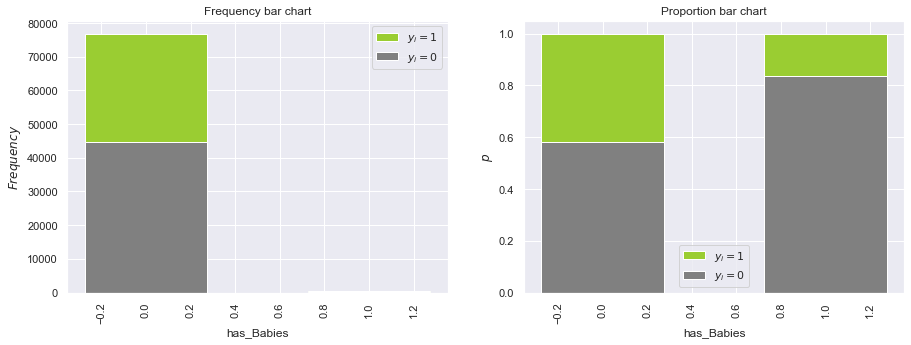

In [129]:
bar_charts_categorical(df_cancel, 'has_Babies', 'Cancel')

In [130]:
df_cancel.drop('Babies', axis=1,inplace=True)
df_cancel.shape

(77178, 25)

##### CREATE room_change , If assigned different room

In [ ]:
# df['room_change'] = np.where(df['ReservedRoomType'] !=df['AssignedRoomType'], '1', '0')
# df[(df['room_change']=="1")&(df['IsCanceled']==1)].head(20)

#checked if assignment made is upon arrival, but no. rooms are assigned beforehand:
# 1- there are assigned room for every reservation
# 2- not all cancellations are made on the day of arrival

In [131]:
df_cancel['room_change'] = np.where(df_cancel['ReservedRoomType'] !=df_cancel['AssignedRoomType'], '1', '0')

In [132]:
df_cancel['room_change'].value_counts()

0    70550
1     6628
Name: room_change, dtype: int64

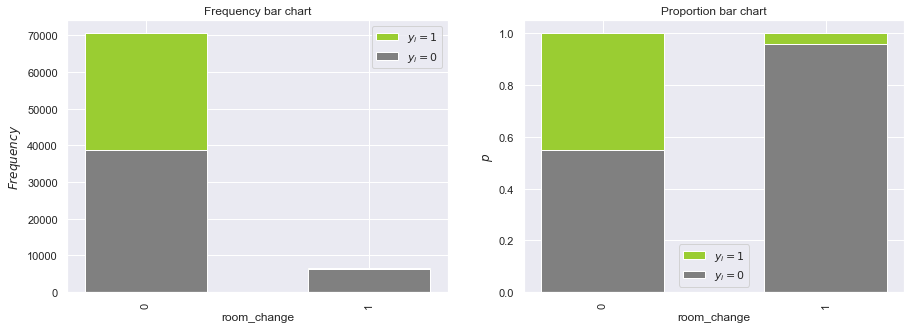

In [133]:
bar_charts_categorical(df_cancel, 'room_change', 'Cancel')

##### DaysInWaitingList

In [134]:
df_cancel['waited'] = np.where(df_cancel['DaysInWaitingList'] ==0 , '0', '1')

In [135]:
df_cancel['waited'].value_counts()

0    73751
1     3427
Name: waited, dtype: int64

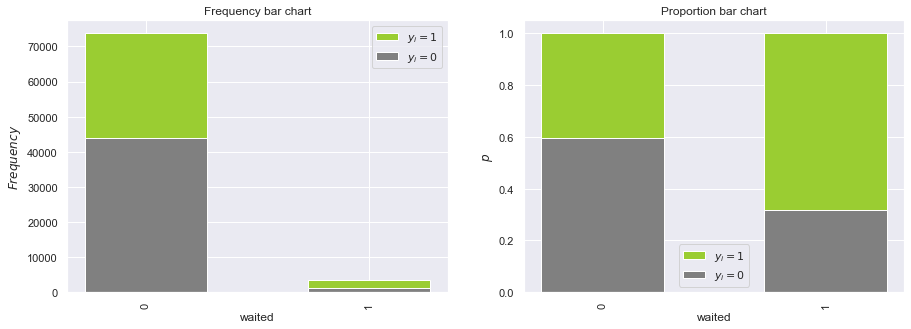

In [136]:
bar_charts_categorical(df_cancel, 'waited', 'Cancel')

In [137]:
df_cancel.drop('DaysInWaitingList',axis=1,inplace=True)

In [251]:
#Create is_weekday if there is no weekend stay, didnt work
#total duration didnt work

##### Made any booking change?

In [138]:
df_cancel['BookingChanges'].value_counts()

0     67396
1      6904
2      2139
3       445
4       181
5        42
6        28
7        16
8         7
9         4
10        3
13        3
14        3
15        3
17        1
11        1
16        1
18        1
Name: BookingChanges, dtype: int64

In [139]:
df_cancel['booking_change'] = np.where(df_cancel['BookingChanges'] ==0 , '0', '1')

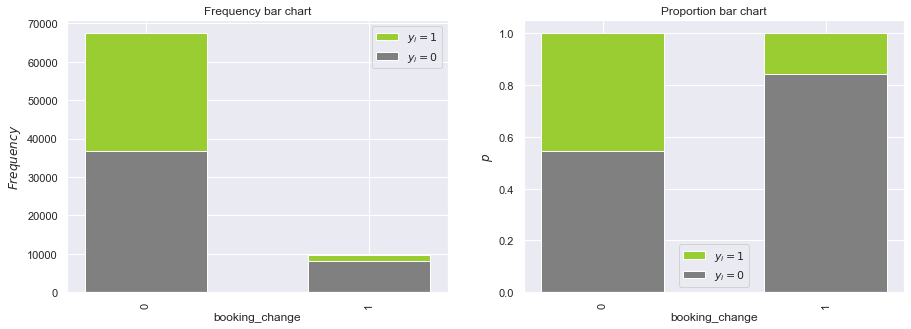

In [140]:
bar_charts_categorical(df_cancel, 'booking_change', 'Cancel')

In [141]:
df_cancel.drop('BookingChanges',axis=1,inplace=True)      

##### Has car??

In [142]:
df_cancel['RequiredCarParkingSpaces'].value_counts()

0    75302
1     1871
2        3
3        2
Name: RequiredCarParkingSpaces, dtype: int64

In [143]:
df_cancel['has_car'] = np.where(df_cancel['RequiredCarParkingSpaces'] ==0 , '0', '1')

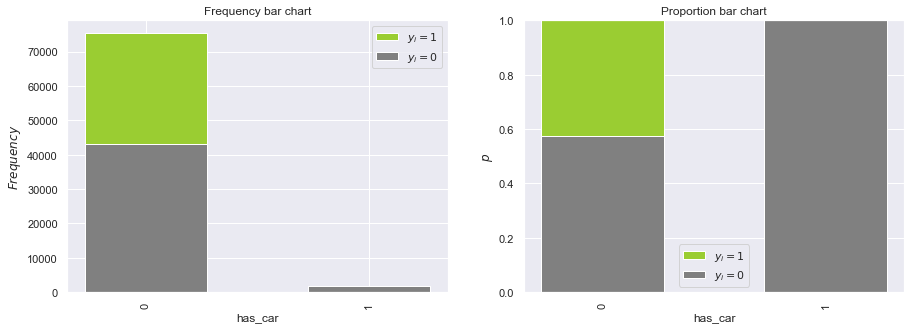

In [144]:
bar_charts_categorical(df_cancel, 'has_car', 'Cancel')

In [145]:
df_cancel.drop('RequiredCarParkingSpaces',axis=1,inplace=True)

##### CREATE has_request

In [146]:
df_cancel['TotalOfSpecialRequests'].value_counts()

0    46684
1    20836
2     7927
3     1526
4      179
5       26
Name: TotalOfSpecialRequests, dtype: int64

In [147]:
df_cancel['has_request'] = np.where(df_cancel['TotalOfSpecialRequests'] ==0 , '0', '1')

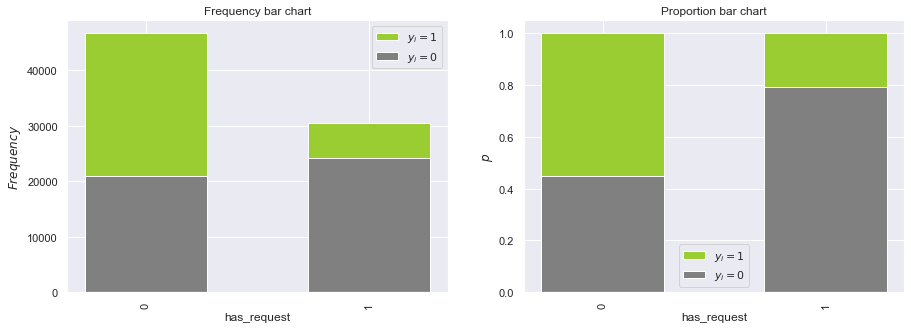

In [148]:
bar_charts_categorical(df_cancel, 'has_request', 'Cancel')

In [149]:
df_cancel.drop('TotalOfSpecialRequests',axis=1,inplace=True)

In [150]:
df_cancel.columns

Index(['LeadTime', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Meal', 'MarketSegment', 'DistributionChannel', 'IsRepeatedGuest',
       'PreviousCancellations', 'PreviousBookingsNotCanceled',
       'ReservedRoomType', 'AssignedRoomType', 'Agent', 'CustomerType', 'ADR',
       'Cancel', 'not_company', 'has_Babies', 'room_change', 'waited',
       'booking_change', 'has_car', 'has_request'],
      dtype='object')

In [151]:
#create new variable named CancellationRate
#replace nans with the probability of first time customer probability of cancellation
df_cancel['CancellationRate'] = df_cancel['PreviousCancellations']/(df_cancel['PreviousCancellations']+df_cancel['PreviousBookingsNotCanceled'])
df_cancel['CancellationRate'] = df_cancel['CancellationRate'].fillna(0.58)

#drop two columns
df_cancel.drop(['PreviousCancellations', 'PreviousBookingsNotCanceled'], axis=1, inplace=True)
df_cancel['CancellationRate']

1        0.58
2        0.58
3        0.58
4        0.58
5        0.58
         ... 
78409    0.58
78410    0.58
78411    0.58
78412    0.58
78413    0.58
Name: CancellationRate, Length: 77178, dtype: float64

In [253]:
#df_cancel.drop('IsRepeatedGuest',axis=1,inplace=True)

In [152]:
df_cancel.head(5)

LeadTime  ArrivalDateWeekNumber  ArrivalDateDayOfMonth  \
1        88                     27                      1   
2        65                     27                      1   
3        92                     27                      1   
4       100                     27                      2   
5        79                     27                      2   

   StaysInWeekendNights  StaysInWeekNights  Adults  Children       Meal  \
1                     0                  4       2       0.0  BB          
2                     0                  4       1       0.0  BB          
3                     2                  4       2       0.0  BB          
4                     0                  2       2       0.0  BB          
5                     0                  3       2       0.0  BB          

  MarketSegment DistributionChannel  ...   ADR Cancel not_company has_Babies  \
1     Online TA               TA/TO  ...  76.5      1           0          0   
2     Online TA               TA/TO  ...  68.0      1           0          0   
3     Online TA               TA/TO  ...  76.5      1           0          0   
4     Online TA               TA/TO  ...  76.5      1           0          0   
5     Online TA               TA/TO  ...  76.5      1           0          0   

  room_change  waited  booking_change has_car  has_request CancellationRate  
1           0       0               0       0            1             0.58  
2           0       0               0       0            1             0.58  
3           0       0               0       0            1             0.58  
4           0       0               0       0            1             0.58  
5           0       0               0       0            1             0.58  

[5 rows x 25 columns]

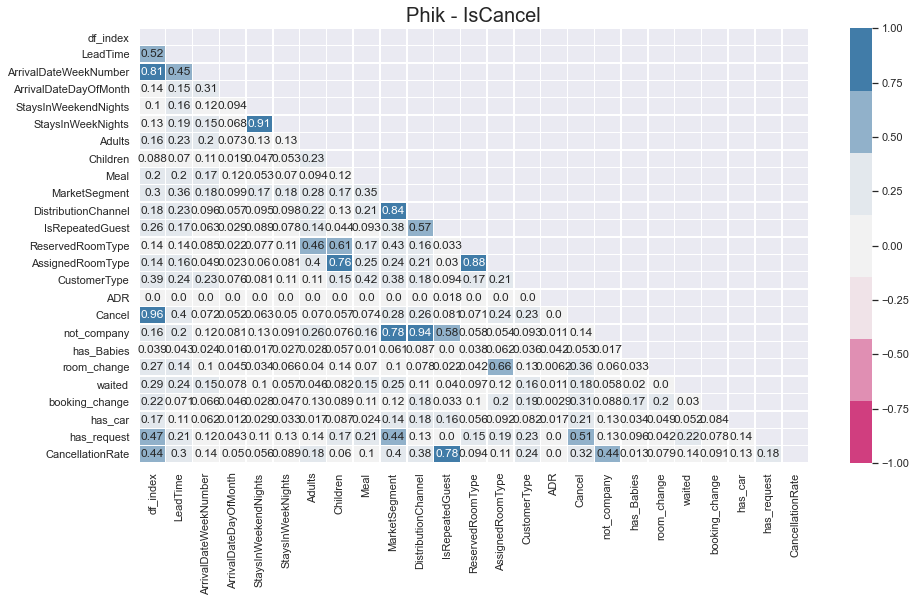

Cancel                   1.000000
df_index                 0.964068
has_request              0.507270
LeadTime                 0.403316
room_change              0.357467
CancellationRate         0.321904
booking_change           0.307903
MarketSegment            0.281071
DistributionChannel      0.263809
AssignedRoomType         0.244663
CustomerType             0.234958
has_car                  0.207303
waited                   0.182479
not_company              0.139276
IsRepeatedGuest          0.080670
Meal                     0.074493
ArrivalDateWeekNumber    0.071593
ReservedRoomType         0.070661
Adults                   0.070033
StaysInWeekendNights     0.063338
Children                 0.056878
has_Babies               0.052713
ArrivalDateDayOfMonth    0.051738
StaysInWeekNights        0.049537
ADR                      0.000000
Name: Cancel, dtype: float64

In [153]:
phi_k_c=get_phi_k_corr(df_cancel,'')
#Print matrix
print_corr_matrix(phi_k_c,'Phik - IsCancel')
phi_k_c.loc[:,'Cancel'].sort_values(ascending=False)

#### Encoding Categorical Variables

In [154]:
df_cancel.columns

Index(['LeadTime', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Meal', 'MarketSegment', 'DistributionChannel', 'IsRepeatedGuest',
       'ReservedRoomType', 'AssignedRoomType', 'Agent', 'CustomerType', 'ADR',
       'Cancel', 'not_company', 'has_Babies', 'room_change', 'waited',
       'booking_change', 'has_car', 'has_request', 'CancellationRate'],
      dtype='object')

In [155]:
metric = ['LeadTime','StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'ADR', 'CancellationRate']
target = ['Cancel']
non_metric= df_cancel.columns.drop(metric)
non_metric= non_metric.drop(target)

In [156]:
non_metric

Index(['ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'Meal',
       'MarketSegment', 'DistributionChannel', 'IsRepeatedGuest',
       'ReservedRoomType', 'AssignedRoomType', 'Agent', 'CustomerType',
       'not_company', 'has_Babies', 'room_change', 'waited', 'booking_change',
       'has_car', 'has_request'],
      dtype='object')

In [285]:
metric

['LeadTime',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'Adults',
 'Children',
 'ADR',
 'CancellationRate']

In [157]:
mean = df_cancel['Cancel'].mean()
for i in non_metric:
    agg = df_cancel.groupby(i)['Cancel'].agg(['count','mean'])
    counts = agg['count']
    means = agg['mean']
    weight  = 100
    #smoothed means
    smooth = (counts * means + weight * mean) / (counts + weight)
    print(smooth)
    df_cancel.loc[:, i + '_enc'] = df_cancel[i].map(smooth)

ArrivalDateWeekNumber
1     0.383266
2     0.414239
3     0.356687
4     0.450865
5     0.401219
6     0.294596
7     0.339622
8     0.398904
9     0.381739
10    0.347390
11    0.350445
12    0.362843
13    0.407757
14    0.426037
15    0.437221
16    0.463194
17    0.486503
18    0.476756
19    0.414255
20    0.489696
21    0.408931
22    0.420607
23    0.455113
24    0.432880
25    0.503707
26    0.376176
27    0.391839
28    0.418781
29    0.379558
30    0.444116
31    0.383633
32    0.419876
33    0.451678
34    0.351838
35    0.378206
36    0.398205
37    0.426659
38    0.417677
39    0.402412
40    0.460854
41    0.421784
42    0.479109
43    0.434683
44    0.367357
45    0.479990
46    0.440878
47    0.291712
48    0.294300
49    0.430572
50    0.500972
51    0.358457
52    0.329211
53    0.420411
dtype: float64
ArrivalDateDayOfMonth
1     0.447166
2     0.380872
3     0.439559
4     0.400858
5     0.430103
6     0.370215
7     0.443419
8     0.481233
9     0.425663
10    0.372

In [158]:
df_enc = df_cancel.drop(non_metric, axis=1)

In [159]:
df_enc

LeadTime  StaysInWeekendNights  StaysInWeekNights  Adults  Children  \
1            88                     0                  4       2       0.0   
2            65                     0                  4       1       0.0   
3            92                     2                  4       2       0.0   
4           100                     0                  2       2       0.0   
5            79                     0                  3       2       0.0   
...         ...                   ...                ...     ...       ...   
78409        23                     2                  5       2       0.0   
78410       102                     2                  5       3       0.0   
78411        34                     2                  5       2       0.0   
78412       109                     2                  5       2       0.0   
78413       205                     2                  7       2       0.0   

          ADR  Cancel  CancellationRate  ArrivalDateWeekNumber_enc  \
1       76.50       1              0.58                   0.391839   
2       68.00       1              0.58                   0.391839   
3       76.50       1              0.58                   0.391839   
4       76.50       1              0.58                   0.391839   
5       76.50       1              0.58                   0.391839   
...       ...     ...               ...                        ...   
78409   96.14       0              0.58                   0.378206   
78410  225.43       0              0.58                   0.378206   
78411  157.71       0              0.58                   0.378206   
78412  104.40       0              0.58                   0.378206   
78413  151.20       0              0.58                   0.378206   

       ArrivalDateDayOfMonth_enc  ...  AssignedRoomType_enc  Agent_enc  \
1                       0.447166  ...              0.470067   0.409496   
2                       0.447166  ...              0.470067   0.409496   
3                       0.447166  ...              0.470067   0.409496   
4                       0.380872  ...              0.470067   0.409496   
5                       0.380872  ...              0.470067   0.409496   
...                          ...  ...                   ...        ...   
78409                   0.463158  ...              0.470067   0.329900   
78410                   0.397424  ...              0.241138   0.409496   
78411                   0.397424  ...              0.280203   0.409496   
78412                   0.397424  ...              0.470067   0.233573   
78413                   0.394593  ...              0.470067   0.409496   

       CustomerType_enc  not_company_enc  has_Babies_enc  room_change_enc  \
1              0.455189         0.424751        0.416582         0.450581   
2              0.455189         0.424751        0.416582         0.450581   
3              0.455189         0.424751        0.416582         0.450581   
4              0.455189         0.424751        0.416582         0.450581   
5              0.455189         0.424751        0.416582         0.450581   
...                 ...              ...             ...              ...   
78409          0.455189         0.424751        0.416582         0.450581   
78410          0.455189         0.424751        0.416582         0.450581   
78411          0.455189         0.424751        0.416582         0.450581   
78412          0.455189         0.424751        0.416582         0.450581   
78413          0.455189         0.424751        0.416582         0.450581   

       waited_enc  booking_change_enc  has_car_enc  has_request_enc  
1        0.403062            0.452835     0.425805         0.209601  
2        0.403062            0.452835     0.425805         0.209601  
3        0.403062            0.452835     0.425805         0.209601  
4        0.403062            0.452835     0.425805         0.209601  
5        0.403062            0.452835     0.425805         0.2096

#### Data Scaling

In [160]:
# #create a scaler object
# scaler = MinMaxScaler()
# # fit and transform the data
# df[metric] = scaler.fit_transform(df[metric])
# df.reset_index(inplace = True)

#create a scaler object
scaler2 = MinMaxScaler()
# fit and transform the data
df_enc[df_enc.columns] = scaler2.fit_transform(df_enc)
df_enc.reset_index(inplace = True)

In [161]:
df_enc.drop('index', axis=1, inplace=True)

# Models

#### Logistic Regression

In [162]:
X_train, X_test, y_train, y_test = train_test_split(df_enc.drop('Cancel', axis=1), df_enc[target], test_size=0.3, random_state=5, stratify=df_enc[target])

In [163]:
log_model = LogisticRegression(max_iter=2000)
log_model.fit(X_train,y_train)
y_pred = log_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred),f1_score(y_test, y_pred))

C:\Users\Admin\anaconda3\envs\dm\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[[11856  1678]
 [ 2691  6929]]
0.8113069016152716 0.7603006528775991


In [164]:
lg = {'Coef' : log_model.coef_.tolist()[0] , 'Feature' : df_enc.columns.drop('Cancel').tolist()}
lg = pd.DataFrame(lg)
lg.sort_values('Coef', ascending=False)

Coef                    Feature
6   9.326979           CancellationRate
22  4.798243                has_car_enc
15  3.919089                  Agent_enc
16  3.803108           CustomerType_enc
5   3.346310                        ADR
0   2.772721                   LeadTime
19  2.539304            room_change_enc
2   1.820795          StaysInWeekNights
23  1.508593            has_request_enc
21  0.997177         booking_change_enc
10  0.704471          MarketSegment_enc
7   0.453961  ArrivalDateWeekNumber_enc
4   0.425935                   Children
13  0.303240       ReservedRoomType_enc
8   0.281220  ArrivalDateDayOfMonth_enc
3   0.218172                     Adults
1   0.217887       StaysInWeekendNights
11  0.140909    DistributionChannel_enc
20  0.079006                 waited_enc
17 -0.287005            not_company_enc
14 -0.357266       AssignedRoomType_enc
9  -0.366909                   Meal_enc
18 -0.474487             has_Babies_enc
12 -1.205484        IsRepeatedGuest_enc

#### K Nearest Neighbors

In [165]:
modelKNN = KNeighborsClassifier(n_neighbors=15)
modelKNN.fit(X = X_train, y = np.ravel(y_train))

#labels_train = modelKNN.predict(X_train)
labels_val = modelKNN.predict(X_test)
print(classification_report(y_test, labels_val))

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86     13534
         1.0       0.84      0.75      0.79      9620

    accuracy                           0.83     23154
   macro avg       0.83      0.82      0.83     23154
weighted avg       0.83      0.83      0.83     23154



In [166]:
f1_score(y_test, labels_val)

0.789092505212334

#### Decision Tree

In [167]:
dt_entropy = DecisionTreeClassifier(criterion = 'entropy', max_depth = 20, max_features = 'auto').fit(X_train, y_train)
y_pred = dt_entropy.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[11797  1737]
 [ 2124  7496]]
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86     13534
         1.0       0.81      0.78      0.80      9620

    accuracy                           0.83     23154
   macro avg       0.83      0.83      0.83     23154
weighted avg       0.83      0.83      0.83     23154



In [168]:
f1_score(y_test, y_pred)

0.7952050071606641

In [178]:
dt = {'Importance' : dt_entropy.feature_importances_ , 'Feature' : df_enc.columns.drop('Cancel')}
imp = pd.DataFrame(dt)
imp.sort_values('Importance', ascending=False).head(30)

Importance                    Feature
0     0.129516                   LeadTime
15    0.114818                  Agent_enc
23    0.105253            has_request_enc
10    0.090077          MarketSegment_enc
5     0.079305                        ADR
16    0.078751           CustomerType_enc
6     0.059734           CancellationRate
7     0.057414  ArrivalDateWeekNumber_enc
8     0.048688  ArrivalDateDayOfMonth_enc
21    0.041799         booking_change_enc
14    0.041732       AssignedRoomType_enc
19    0.034550            room_change_enc
2     0.029012          StaysInWeekNights
1     0.018252       StaysInWeekendNights
9     0.015757                   Meal_enc
22    0.013420                has_car_enc
3     0.012570                     Adults
11    0.009950    DistributionChannel_enc
13    0.005789       ReservedRoomType_enc
4     0.005090                   Children
20    0.003745                 waited_enc
17    0.002385            not_company_enc
12    0.001449        IsRepeatedGuest_enc
18    0.000945             has_Babies_enc

In [244]:
gb = GradientBoostingClassifier(random_state = 5, learning_rate=0.20, n_estimators=300, max_features=12, max_depth=3)
gb.fit(X_train[features_to_use], y_train)
y_pred_gb = gb.predict(X_test[features_to_use])
f1_score(y_test, y_pred_gb, average = 'micro')

C:\Users\Admin\anaconda3\envs\dm\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.848190377472575

In [192]:
y_pred_train = gb.predict(X_train)
f1_score( y_train,y_pred_train, average = 'micro')

0.8535095513105286

In [239]:
features_to_use =['LeadTime', 'Agent_enc', 'has_request_enc', 'CustomerType_enc',
       'ADR', 'CancellationRate', 'ArrivalDateWeekNumber_enc',
       'ArrivalDateDayOfMonth_enc', 'MarketSegment_enc',
       'room_change_enc', 'StaysInWeekNights', 'booking_change_enc',
       'StaysInWeekendNights']

In [240]:
modelRF = RandomForestClassifier(class_weight = 'balanced',criterion = 'entropy', max_depth =20, max_samples = 0.4, n_estimators = 300, random_state = 5)
modelRF.fit(X_train[features_to_use], y_train)
y_pred = modelRF.predict(X_test[features_to_use])
f1_score(y_test,y_pred,average = 'micro')

<ipython-input-240-5a805471ac2b>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.8655523883562235

In [241]:
label_train = modelRF.predict(X_train[features_to_use])
f1_score(y_train,label_train,average = 'micro')

0.8913816081741448

In [242]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89     13534
         1.0       0.88      0.79      0.83      9620

    accuracy                           0.87     23154
   macro avg       0.87      0.85      0.86     23154
weighted avg       0.87      0.87      0.86     23154



In [243]:
# dt = {'Importance' : modelRF.feature_importances_ , 'Feature' : X_train.columns}
# imp = pd.DataFrame(dt)
# imp = imp.sort_values('Importance', ascending=False)
# imp['cum_imp'] = imp.Importance.cumsum().values
# imp=imp.reset_index().drop('index', axis=1)
# imp